In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [10]:
def load_and_preprocess():
    # Load all datasets
    climate = pd.read_csv("./Downloads/Climate_Data_Wide.csv")
    ndvi = pd.read_csv("./Downloads/NDVI_VCI_India_States.csv")
    icrisat = pd.read_csv("./Desktop/ICRISAT-District-Level-Data.csv")

    # Enhanced column standardization
    def standardize_columns(df):
        df.columns = (
            df.columns.str.strip()
            .str.upper()
            .str.replace(' ', '_')
            .str.replace('-', '_')
        )
        return df

    # Apply standardization
    climate = standardize_columns(climate)
    ndvi = standardize_columns(ndvi)
    icrisat = standardize_columns(icrisat)


    # Verify critical columns exist
    required_columns = {
        'icrisat': ['STATE_NAME', 'DIST_NAME', 'YEAR'],
        'ndvi': ['STATE', 'NDVI', 'VCI_(%)'],
        'climate': ['LATITUDE','LONGITUDE','DISTRICT_NAME', 'YEAR', 'RH2M', 'T2M', 'GDD', 'T2M_MAX']
    }

    # Validate all datasets
    for df_name, cols in required_columns.items():
        missing = [col for col in cols if col not in locals()[df_name].columns]
        if missing:
            print(f"{df_name.upper()} columns:", locals()[df_name].columns.tolist())
            raise ValueError(f"Missing in {df_name}: {missing}")

    # Perform merges with verified columns
    merged = icrisat.merge(
        ndvi[required_columns['ndvi']],
        left_on='STATE_NAME',
        right_on='STATE',
        how='left'
    ).merge(
        climate[required_columns['climate']],
        left_on=['DIST_NAME', 'YEAR'],
        right_on=['DISTRICT_NAME', 'YEAR'],
        how='inner'
    )
    # Feature engineering
    merged['RH2M'] = merged['RH2M'].replace(0, np.nan)
    merged['Moisture_Stress'] = merged['T2M'] / merged['RH2M']
    merged['Thermal_Time'] = merged['GDD'] * merged['T2M_MAX']
    
    # Final cleanup
    merged.to_csv("./Downloads/preprocessed_crop_data.csv", index=False)
    return merged.dropna(thresh=merged.shape[1]-3)

load_and_preprocess()

,DIST_CODE,YEAR,STATE_CODE,STATE_NAME,DIST_NAME,RICE_AREA_(1000_HA),RICE_PRODUCTION_(1000_TONS),RICE_YIELD_(KG_PER_HA),WHEAT_AREA_(1000_HA),WHEAT_PRODUCTION_(1000_TONS),...,VCI_(%),LATITUDE,LONGITUDE,DISTRICT_NAME,RH2M,T2M,GDD,T2M_MAX,Moisture_Stress,Thermal_Time
0,1,2008,14,Chhattisgarh,Durg,803.37,704.09,876.42,36.46,31.19,...,100.0,21.2,81.3,Durg,61.06,25.62,15.62,45.10,0.419587,704.4620
1,1,2009,14,Chhattisgarh,Durg,789.04,622.05,788.37,42.44,38.12,...,100.0,21.2,81.3,Durg,55.62,26.91,16.91,46.28,0.483819,782.5948
2,1,2010,14,Chhattisgarh,Durg,777.92,1319.18,1695.77,46.12,45.87,...,100.0,21.2,81.3,Durg,58.98,26.75,16.75,47.34,0.453544,792.9450
3,1,2011,14,Chhattisgarh,Durg,806.55,1416.48,1756.23,44.98,50.19,...,100.0,21.2,81.3,Durg,63.88,25.27,15.27,44.70,0.395585,682.5690
4,1,2012,14,Chhattisgarh,Durg,807.07,1534.22,1900.97,43.87,47.69,...,100.0,21.2,81.3,Durg,60.68,25.82,15.82,47.26,0.425511,747.6532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,916,2013,15,Jharkhand,Ranchi,353.05,714.66,2024.25,6.12,11.88,...,66.7,23.4,85.0,Ranchi,65.72,22.75,12.75,42.92,0.346166,547.2300
2846,916,2014,15,Jharkhand,Ranchi,316.66,658.31,2078.92,12.63,22.81,...,66.7,23.4,85.0,Ranchi,63.07,23.03,13.03,42.00,0.365150,547.2600
2847,916,2015,15,Jharkhand,Ranchi,370.06,352.66,952.98,6.90,10.48,...,66.7,23.4,85.0,Ranchi,62.01,23.59,13.59,43.22,0.380423,587.3598
2848,916,2016,15,Jharkhand,Ranchi,550.38,1195.51,2172.16,22.78,48.17,...,66.7,23.4,85.0,Ranchi,60.98,23.92,13.92,42.77,0.392260,595.3584


In [11]:
# Check for MPS availability
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create directory for saving models and plots
os.makedirs("saved_models", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# --------------------------
# 1. Data Loading and Preparation
# --------------------------
def load_preprocessed():
    df = pd.read_csv("./Downloads/preprocessed_crop_data.csv")
    
    # Updated feature columns matching your dataset
    feature_cols = [
        'T2M',                # Temperature
        'RH2M',               # Relative Humidity
        'NDVI',               # Vegetation Index
        'VCI_(%)',            # Vegetation Condition Index
        'GDD',                # Growing Degree Days
        'Moisture_Stress',    # New feature
        'Thermal_Time',       # New feature
        'LATITUDE',         # State identifier (latitude proxy)
        'LONGITUDE'           # District identifier (longitude proxy)
    ]
    
    # Yield columns (already correct in your code)
    yield_cols = [col for col in df.columns if 'YIELD' in col]
    
    # Handle missing values
    X = df[feature_cols].fillna(df[feature_cols].median())
    Y = df[yield_cols].fillna(0)
    
    return X.values, Y.values
# Load and split data
X, Y = load_preprocessed()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "saved_models/feature_scaler.joblib")

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(Y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), torch.FloatTensor(Y_test))

# --------------------------
# 2. Model Architectures 
# --------------------------
class DeepFusionNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.climate_dim = input_dim - 2
        self.climate_fc = nn.Sequential(
            nn.Linear(self.climate_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128)
        )
        self.geo_fc = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.LayerNorm(32)
        )
        self.attention = nn.MultiheadAttention(embed_dim=160, num_heads=4)
        self.fc = nn.Sequential(
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        climate = x[:, :-2]
        geo = x[:, -2:]
        climate_feat = self.climate_fc(climate)
        geo_feat = self.geo_fc(geo)
        combined = torch.cat([climate_feat, geo_feat], dim=1)
        attn_out, _ = self.attention(combined.unsqueeze(0), combined.unsqueeze(0), combined.unsqueeze(0))
        return self.fc(attn_out.squeeze(0))

class CNNLSTM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(64, 128, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


# --------------------------
# 3. Training Utilities
# --------------------------
def train_pytorch_model(model, train_loader, test_loader, epochs=300):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.HuberLoss()
    
    history = {
        'train_loss': [],
        'val_loss': []
    }
    
    best_rmse = float('inf')
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        
        # Store training loss
        history['train_loss'].append(total_loss/len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        preds = []
        truths = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                preds.append(outputs.cpu().numpy())
                truths.append(yb.cpu().numpy())
                val_loss += criterion(outputs, yb).item()
        
        # Store validation loss
        history['val_loss'].append(val_loss/len(test_loader))
        val_rmse = np.sqrt(mean_squared_error(np.concatenate(truths), np.concatenate(preds)))
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save(model.state_dict(), f"saved_models/best_{model.__class__.__name__}.pth")
        
        print(f"Epoch {epoch+1}: Train Loss={history['train_loss'][-1]:.4f}, Val Loss={history['val_loss'][-1]:.4f}, Val RMSE={val_rmse:.2f}")
    
    return history

def calculate_regression_metrics(y_true, y_pred, n_features):
    """Calculates comprehensive regression metrics"""
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100,
        'MBE': np.mean(y_pred - y_true),
        'R2': r2_score(y_true, y_pred),
        'MedianAE': median_absolute_error(y_true, y_pred)
    }
    
    # Adjusted R² calculation
    n_samples = y_true.shape[0]
    metrics['Adjusted R2'] = 1 - (1 - metrics['R2']) * (n_samples - 1) / (n_samples - n_features - 1)
    
    # COD (Coefficient of Determination) same as R²
    metrics['COD'] = metrics['R2']
    
    return metrics

def plot_regression_metrics(metrics_dict):
    """Plots all regression metrics in a grid"""
    metrics = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MBE', 'Adjusted R2', 'COD', 'MedianAE']
    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    
    for i, metric in enumerate(metrics):
        ax = axs[i//3, i%3]
        values = [metrics_dict[name][metric] for name in metrics_dict]
        sns.barplot(x=list(metrics_dict.keys()), y=values, ax=ax)
        ax.set_title(metric)
        ax.tick_params(axis='x', rotation=45)
        if metric == 'MAPE':
            ax.set_ylabel('Percentage (%)')
    
    # Hide empty subplot
    axs[2, 2].axis('off')
    plt.tight_layout()
    plt.savefig("plots/regression_metrics.png")
    plt.close()

# --------------------------
# 4. Model Training
# --------------------------
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = X_train_scaled.shape[1]
output_dim = Y_train.shape[1]

models = {
    "DeepFusionNN": DeepFusionNN(input_dim, output_dim),
    "CNNLSTM": CNNLSTM(input_dim, output_dim)
}

# Train deep learning models
model_history = {}
for name, model in models.items():
    print(f"\nTraining {name}")
    model_history[name] = train_pytorch_model(model, train_loader, test_loader)


# Train and save traditional models
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=500, max_depth=12, random_state=42))
rf.fit(X_train_scaled, Y_train)
joblib.dump(rf, "saved_models/RandomForest.joblib")

xgb = MultiOutputRegressor(XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7))
xgb.fit(X_train_scaled, Y_train)
joblib.dump(xgb, "saved_models/XGBoost.joblib")

Using device: mps

Training DeepFusionNN
Epoch 1: Train Loss=1379.1905, Val Loss=1343.8665, Val RMSE=1897.16
Epoch 2: Train Loss=1088.9971, Val Loss=909.1136, Val RMSE=1252.70
Epoch 3: Train Loss=842.3651, Val Loss=857.7322, Val RMSE=1254.85
Epoch 4: Train Loss=804.6837, Val Loss=842.0771, Val RMSE=1265.49
Epoch 5: Train Loss=787.3224, Val Loss=830.0986, Val RMSE=1253.91
Epoch 6: Train Loss=776.3058, Val Loss=823.2318, Val RMSE=1253.08
Epoch 7: Train Loss=768.9487, Val Loss=819.7289, Val RMSE=1249.80
Epoch 8: Train Loss=767.0950, Val Loss=818.2182, Val RMSE=1237.93
Epoch 9: Train Loss=761.5250, Val Loss=812.4603, Val RMSE=1239.22
Epoch 10: Train Loss=759.0977, Val Loss=804.5572, Val RMSE=1225.03
Epoch 11: Train Loss=740.2456, Val Loss=769.9425, Val RMSE=1187.26
Epoch 12: Train Loss=673.8105, Val Loss=677.0159, Val RMSE=1048.30
Epoch 13: Train Loss=625.5612, Val Loss=654.4757, Val RMSE=1017.16
Epoch 14: Train Loss=607.9547, Val Loss=643.5258, Val RMSE=1020.18
Epoch 15: Train Loss=600.84

['saved_models/XGBoost.joblib']

/var/folders/04/9k6b0tdn3x70tksnfdsj2k5h0000gn/T/ipykernel_60807/194894430.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"saved_mod

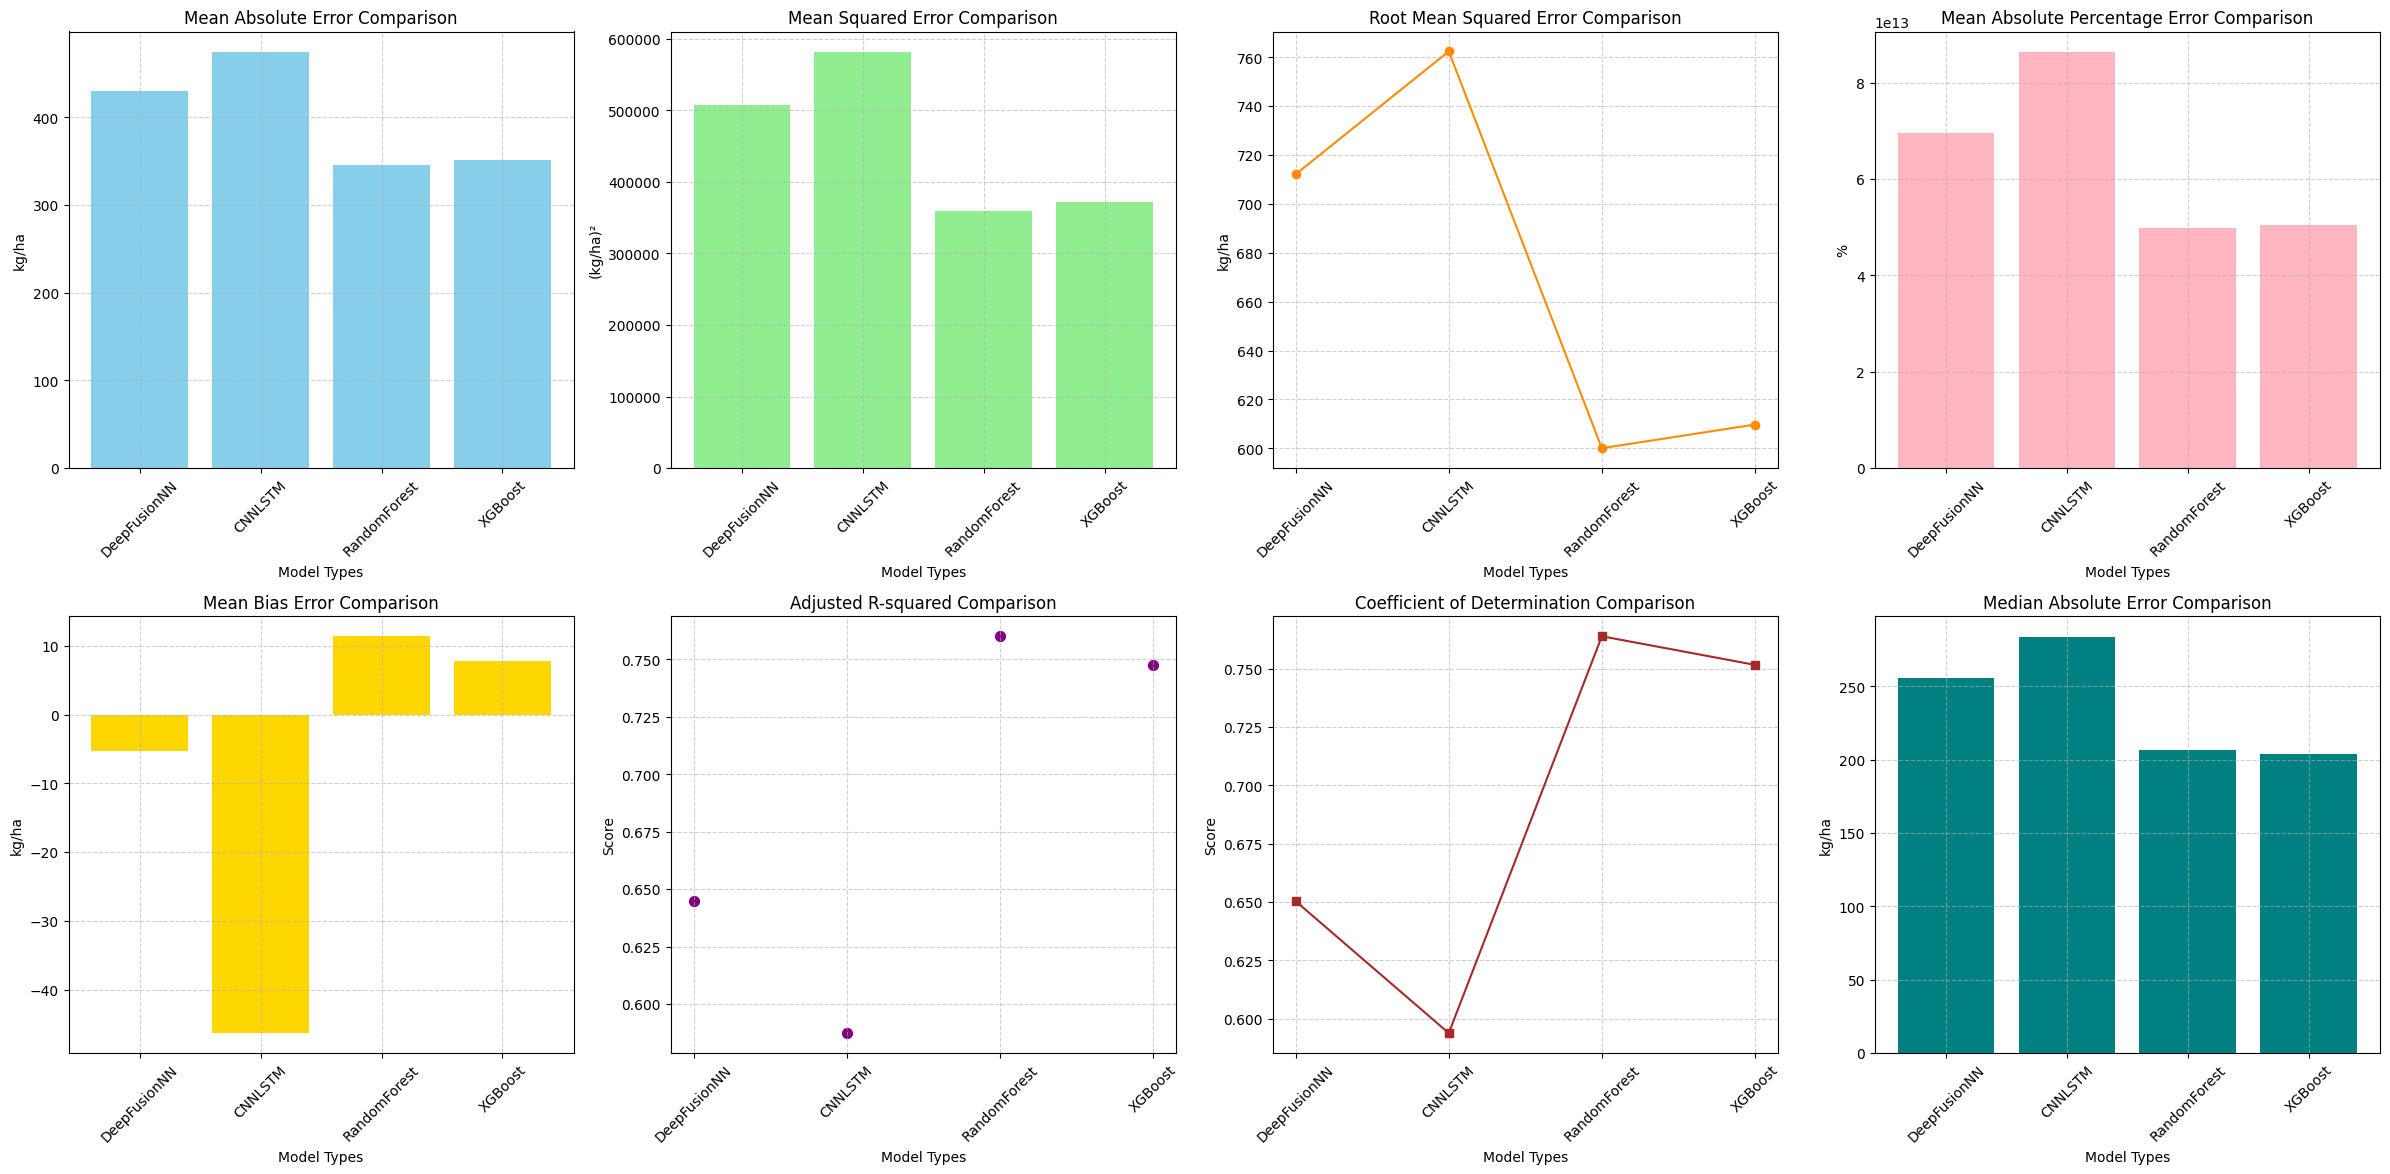

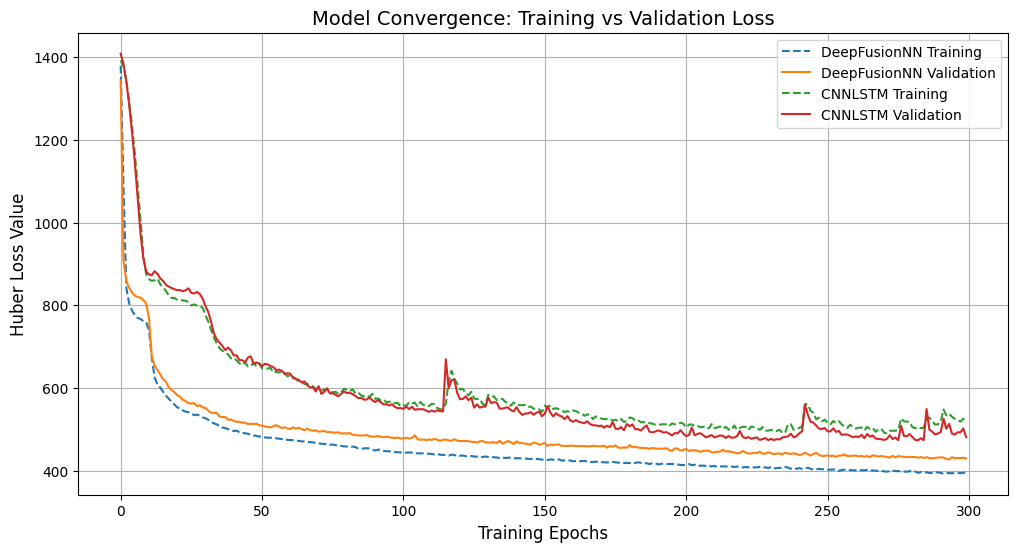

In [16]:
# --------------------------
# 5. Enhanced Evaluation with Visualization (Improved Labeling)
# --------------------------
def plot_metric_comparison(metrics_dict):
    """Plots comparison of all metrics with enhanced axis labels"""
    metrics = ['MAE', 'MSE', 'RMSE', 'MAPE', 'MBE', 'Adjusted R2', 'COD', 'MedianAE']
    
    # Define full metric names and units for axis labels
    metric_labels = {
        'MAE': ('Mean Absolute Error', 'kg/ha'),
        'MSE': ('Mean Squared Error', '(kg/ha)²'),
        'RMSE': ('Root Mean Squared Error', 'kg/ha'),
        'MAPE': ('Mean Absolute Percentage Error', '%'),
        'MBE': ('Mean Bias Error', 'kg/ha'),
        'Adjusted R2': ('Adjusted R-squared', 'Score'),
        'COD': ('Coefficient of Determination', 'Score'),
        'MedianAE': ('Median Absolute Error', 'kg/ha')
    }

    # Create 2x4 grid of subplots
    fig, axs = plt.subplots(2, 4, figsize=(24, 12))
    
    # Plot configurations with enhanced labels
    plot_types = {
        'MAE': {'type': 'bar', 'color': 'skyblue'},
        'MSE': {'type': 'bar', 'color': 'lightgreen'},
        'RMSE': {'type': 'line', 'color': 'darkorange', 'marker': 'o'},
        'MAPE': {'type': 'bar', 'color': 'lightpink'},
        'MBE': {'type': 'bar', 'color': 'gold'},
        'Adjusted R2': {'type': 'scatter', 'color': 'purple'},
        'COD': {'type': 'line', 'color': 'brown', 'marker': 's'},
        'MedianAE': {'type': 'bar', 'color': 'teal'}
    }
    
    for idx, metric in enumerate(metrics):
        row = idx // 4
        col = idx % 4
        ax = axs[row, col]
        values = [metrics_dict[name][metric] for name in metrics_dict]
        model_names = list(metrics_dict.keys())
        
        # Set plot type
        if plot_types[metric]['type'] == 'bar':
            ax.bar(model_names, values, color=plot_types[metric]['color'])
        elif plot_types[metric]['type'] == 'line':
            ax.plot(model_names, values, 
                   marker=plot_types[metric].get('marker', 'o'),
                   color=plot_types[metric]['color'])
        elif plot_types[metric]['type'] == 'scatter':
            ax.scatter(model_names, values, c=plot_types[metric]['color'], s=50)  # s=200 makes markers larger

        
        # Set axis labels and titles
        ax.set_xlabel('Model Types', fontsize=10)
        ax.set_ylabel(metric_labels[metric][1], fontsize=10)
        ax.set_title(f"{metric_labels[metric][0]} Comparison", fontsize=12)
        
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig("plots/metric_comparison_grid.png")
    plt.show()
    plt.close()

def plot_training_curves(model_history):
    """Plots training curves with enhanced labels"""
    plt.figure(figsize=(12, 6))
    for model_name, history in model_history.items():
        plt.plot(history['train_loss'], label=f'{model_name} Training', linestyle='--')
        plt.plot(history['val_loss'], label=f'{model_name} Validation')
    
    plt.title('Model Convergence: Training vs Validation Loss', fontsize=14)
    plt.xlabel('Training Epochs', fontsize=12)
    plt.ylabel('Huber Loss Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig("plots/training_curves.png")
    plt.show()
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """Enhanced scatter plot with proper labeling"""
    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_true.flatten(), y=y_pred.flatten(), 
               scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.plot([y_true.min(), y_true.max()], 
            [y_true.min(), y_true.max()], 'k--', label='Perfect Prediction')
    
    plt.xlabel('Actual Crop Yield (kg/ha)', fontsize=12)
    plt.ylabel('Predicted Crop Yield (kg/ha)', fontsize=12)
    plt.title(f'{model_name}: Actual vs Predicted Values', fontsize=14)
    plt.legend()
    plt.savefig(f"plots/{model_name}_actual_vs_predicted.png")
    plt.show()
    plt.close()

def plot_error_distribution(y_true, y_pred, model_name):
    """Error distribution plot with clear labels"""
    errors = y_pred.flatten() - y_true.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, color='purple', bins=30)
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    
    plt.title(f'{model_name}: Prediction Error Distribution', fontsize=14)
    plt.xlabel('Prediction Error (kg/ha)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.savefig(f"plots/{model_name}_error_distribution.png")
    plt.show()
    plt.close()


results = {}
n_features = X_test_scaled.shape[1]  # Critical for Adjusted R²

# Evaluate deep learning models
for name in models:
    model = models[name]
    model.load_state_dict(torch.load(f"saved_models/best_{name}.pth"))
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
    results[name] = calculate_regression_metrics(Y_test, y_pred, n_features)

# Evaluate traditional models
for name in ["RandomForest", "XGBoost"]:
    model = joblib.load(f"saved_models/{name}.joblib")
    y_pred = model.predict(X_test_scaled)
    results[name] = calculate_regression_metrics(Y_test, y_pred, n_features)

# Generate all visualizations
plot_metric_comparison(results)
plot_training_curves(model_history)

In [13]:
!pip install fastapi pydantic typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 88.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=be1eb27c13fad0eab8c1b44fe140db19c3abcee340d98a9c8276ec810b82eec0
  Stored in directory: /Users/rishabhrajsrivastava/Library/Caches/pip/wheels/12/98/52/2bffe242a9a487f00886e43b8ed8dac46456702e11a0d6abef
Successfully built typing
  Attempting uninstall: typi